In [ ]:
1

1

图像分割包含语义分割与实例分割。语义分割（Semantic Segmentation）需要判断输入图像的每一个像素点属于哪一类的标签。在语义分割的基础上，实例分割（Instance Segmentation）还需要区分出同一类中的不同个体。如下图中，左图为语义分割的结果，只能识别出五个人，不能区分个体；右图为实例分割的结果，可以用不同颜色表示出不同的人。本案例介绍两阶段算法Mask R-CNN，以及单阶段算法YOLACT实现实例分割。

![png](http://cookdata.cn/media/note_images/语义分割-实例分割_1608513502822_5d14.jpg)

# 目录
[1. 数据集简介](#1)<br>
[2. 数据预处理](#2)<br>
[3. Mask R-CNN模型介绍](#3)<br>
[4. 模型构建](#4)<br>
[5. 模型训练](#5)<br>
[6. Mask R-CNN分割效果](#6)<br>
[7. YOLACT模型结构](#7)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[7.1 Backbone](#7.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[7.2 FPN](#7.2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[7.3 Protonet](#7.3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[7.4 Prediction Head](#7.4)<br>
[8. YOLACT分割效果](#8)<br>
[9. 总结](#9)<br>


<div id="1"></div>
# 1 数据集简介

案例中使用Penn-Fudan行人检测数据集，数据集大小为51.5MB，包含170张图像，主要用于行人检测和实例分割。图像中的场景主要为校园、城市街道，每张图像中包含一个或多个行人。

该数据集包含两个文件夹，“PNGImages”下为行人图像，每张图像的大小不一，都为彩色图像。“PedMasks”中储存每张行人图像对应的实例分割标注结果，所有被标注的行人都是直立行走的状态，标注框大小在$180 \times 390$之间。


In [ ]:
![png](http://cookdata.cn/media/note_images/Penn-Fudan_1608513511970_5d14.jpg)

<div id="2"></div>
# 2 数据预处理

本节介绍如何加载Penn-Fudan行人检测数据集，读取原图像及对应标注框的数据。

首先读取`PennFudanPed.zip`数据集，获取原始图像及标注结果。


In [ ]:
# 读取压缩为zip文件的数据集
import os
!apt install unzip
!unzip PennFudanPed.zip

再加载需要调用的函数和库，以便后续调用。

In [ ]:
cp coco_eval.py ../

In [ ]:
cp coco_utils.py ../

In [ ]:
cp engine.py ../

In [ ]:
cp transforms.py ../

In [ ]:
cp utils.py ../

In [ ]:
import torch
import numpy as np
import torch.utils.data
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import utils
import transforms as T
from engine import train_one_epoch, evaluate
import cv2
from random import shuffle
from matplotlib import pyplot as plt
import random
import math
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from pathlib import Path

标注图像中，“0”代表背景，不同的行人个体用不同的数字表示。如下图中包含两个行人，则其对应的分割图像中，用“0”表示背景，“1”、“2”表示两个行人。

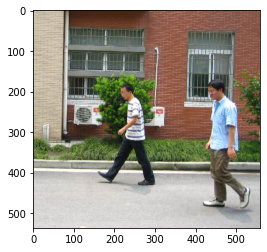

分割图像中像素值类别：  [0, 1, 2]


In [ ]:
# 原始图像
img = Image.open("/content/PennFudanPed/PNGImages/FudanPed00001.png").convert("RGB")
plt.imshow(img)
plt.show()

# 分割图像
mask = Image.open("/content/PennFudanPed/PedMasks/FudanPed00001_mask.png")
mask = np.array(mask)
obj_ids = np.unique(mask)
print("分割图像中像素值类别： ",list(obj_ids))

In [ ]:
obj_ids = obj_ids[1:]
masks = mask == obj_ids[:, None, None]
num_objs = len(obj_ids)
print("行人个数： ",num_objs)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])
print("标注框位置：", boxes)

行人个数：  2
标注框位置： [[159, 181, 301, 430], [419, 170, 534, 485]]


接下来定义数据转换函数`get_transform`，将图像数据转换为Tensor格式的数据，便于进行模型训练。
同时考虑到数据集较小，为增加训练数据，在训练模型的时候，对图像进行随机水平翻转，实现数据增强。
      

In [ ]:
def get_transform(train):
    transforms = []
    # 将图像转换为Tensor格式
    transforms.append(T.ToTensor())
    if train:
        # 随机水平翻转图像，概率为0.5
        transforms.append(T.RandomHorizontalFlip(0.5)) 
    return T.Compose(transforms)


现在，我们将上述处理过程封装为类`PennFudanDataset`，便于后续调用。首先读取所有的原始图像、分割图像名称；再读取每张图像中行人个数、行人标注框位置等信息；最后对图像进行格式转换。

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # 读取所有的行人图像名称
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'PNGImages'))))
        # 读取对应的标注图像名称
        self.masks = list(sorted(os.listdir(os.path.join(root, 'PedMasks'))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        # 加载图像和掩码
        img = Image.open(img_path).convert("RGB") 
        mask = Image.open(mask_path)
        # 标注图像转化为数组
        mask = np.array(mask)
        # 去除数组中的重复数字,并进行排序之后输出
        obj_ids = np.unique(mask)
        # 0代表背景, 删去
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]

        # 找到每个行人对应的标注框位置
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # 分割类别为一类：行人
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        # 标注框的大小
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # 假设所有行人的相对位置都是不拥挤的
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # 保存图像中行人的标注框、图像名称
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # 进行图像转换
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


通过调用类`PennFudanDataset`和函数`get_transform`，我们获取了经过图像增强的集合`dataset`和未经过图像增强的集合`dataset_test`。

In [ ]:
dataset_dir='/content/PennFudanPed'
dataset = PennFudanDataset(dataset_dir, get_transform(train=True))
dataset_test = PennFudanDataset(dataset_dir, get_transform(train=False))

从经过图像增强的集合中，随机选取120张图像，作为训练集；从未经过图像增强的集合中，选择剩余50张图像作为测试集。

In [ ]:
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
print("训练集： ",len(dataset))
print("测试集： ",len(dataset_test))

训练集：  120
测试集：  50


通过`torch.utils.data.DataLoader`函数封装数据，在模型训练时，可以分批次读取数据。

In [ ]:
# 将数据分割为多批次
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

<div id="3"></div>
# 3 模型介绍

为实现实例分割，本案例采用Mask R-CNN模型。

Mask R-CNN的结构以Faster R-CNN为基础，并为达到更好的分割精度，进行了改进：

+ 在基础网络中采用了ResNet-FPN结构，多层特征图有利于多尺度物体及小物体的检测

+ 提出了RoI Align方法来替代RoI Pooling。通过双线性插值的方法获得多个采样点的值，再将多个采样点进行最大值的池化，这样得到的最终值精度较高，适合于分割任务

+ 得到感兴趣区域的特征后，在原来分类与回归的基础上，增加了一个Mask分支来预测每一个像素的类别

下图展示了Mask R-CNN的网络结构。

<div id="4"></div>
# 4 模型构建

这一部分介绍如何构建Mask R-CNN模型。

通过`torchvision.models.detection.maskrcnn_resnet50_fpn`函数，能够调用COCO上预训练的Mask R-CNN模型。该模型能够较准确识别出COCO数据集中不同类别的物体，并进行图像分割。

为了使该模型更适用于Penn-Fudan行人检测数据集，我们调用预训练的Mask R-CNN模型，修改网络最后一层进行训练，达到微调模型的效果。

In [ ]:
def get_instance_segmentation_model(num_classes):
    # 加载预训练的Mask R-CNN模型
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
 
    # 获取分类器的输入参数的数量
    in_features = model.roi_heads.box_predictor.cls_score.in_features
 
    # 微调最后一层，替换预先训练好的参数
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
    # 获取掩膜（Mask）分类器的输入特征数
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
 
    # 用新的掩膜预测器替换预训练好的掩膜预测器
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)
 
    return model

构建训练一个Epoch（所有训练样本都训练一次）的函数。

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    # 模型训练
    model.train()

    # 记录模型训练过程中损失值、训练批次等数据
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]: '.format(epoch)
    lr_scheduler = None
    if epoch == 0:
        # 调用utils中的warmup_lr_scheduler函数，修改学习率
        # 训练最初使用较小的学习率，之后切换到较大学习率
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    # 读取原始数据和标注数据
    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # 调用模型进行图像分割，并计算损失值
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # 计算平均损失值
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value): # 检查损失值是否为有限值
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1) # 若发生错误，退出程序

        # 优化参数、反向传播
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        # 记录并更新损失值、学习率
        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


<div id="5"></div>
# 5 模型训练

读取数据、构建模型后，我们可以调用建立的模型进行训练，并观察分割效果。

先对模型需要的参数进行赋值。




In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2 # 模型需要识别出“行人”和“背景”两类

建立模型，并选择优化算法、损失函数。

In [ ]:
# 建立模型
model = get_instance_segmentation_model(num_classes)
model.to(device)
 
# 选择优化函数
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
 
# 调整学习率
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


现在可以进行模型的训练，考虑到模型已经在COCO数据集上进行了预训练，我们只需训练少数Epoch，即可达到较好的效果。

模型训练中，打印输出的内容包括：
+ `eta`：训练时间
+ `lr`：学习率
+ `loss`：总损失值
+ `loss_classifier`：识别物体类别的损失值
+ `loss_box_reg`：标注框损失值
+ `loss_mask`：分割结果损失值
+ `loss_objectness`：分类器的损失，分类器识别标注框为感兴趣的对象还是背景
+ `loss_rpn_box_reg`：边界框回归器的损失
+ `max mem`：分配到的最大内存（以MB为单位）

IoU是两个区域重叠的部分，除以两个区域的集合部分得到的数值，这里代表着预测标注框和实际标注框是否一致。模型给出了对于不同的阈值，通过计算IoU，分析模型分割精度的结果。

+ IoU=0.50：IoU大于0.5被认为是检测到目标
+ IoU=0.50:0.95：IoU在0.5到0.95的范围内被认为是检测到目标
+ IoU阈值越低，判为正确检测的越多；检测精度（Average Precision）也越高

+ small：标注框面积小于$32\times 32$
+ medium：标注框面积小于$96\times 96$
+ large：标注框面积大于等于$96\times 96$
+ all：所有标注框
+ maxDets：最大检测目标数

由训练结果可以看到，总损失值`loss`不断下降，由4左右逐步下降至0.2上下，证明模型分割效果在不断优化。

In [ ]:
# 训练的Epoch数量
num_epochs = 2
for epoch in range(num_epochs):
    # 训练一次Epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
 
    # 更新学习率
    lr_scheduler.step()
 
    # 分析模型在测试集上的分割效果
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]:   [ 0/60]  eta: 0:01:22  lr: 0.000090  loss: 4.6415 (4.6415)  loss_classifier: 0.7949 (0.7949)  loss_box_reg: 0.3921 (0.3921)  loss_mask: 3.4276 (3.4276)  loss_objectness: 0.0213 (0.0213)  loss_rpn_box_reg: 0.0056 (0.0056)  time: 1.3775  data: 0.3641  max mem: 2302
Epoch: [0]:   [10/60]  eta: 0:00:30  lr: 0.000936  loss: 1.7291 (2.2541)  loss_classifier: 0.4501 (0.4679)  loss_box_reg: 0.2963 (0.2845)  loss_mask: 1.0088 (1.4770)  loss_objectness: 0.0213 (0.0200)  loss_rpn_box_reg: 0.0040 (0.0047)  time: 0.6162  data: 0.0385  max mem: 2854
Epoch: [0]:   [20/60]  eta: 0:00:23  lr: 0.001783  loss: 0.9481 (1.5310)  loss_classifier: 0.2073 (0.3266)  loss_box_reg: 0.2250 (0.2571)  loss_mask: 0.3999 (0.9175)  loss_objectness: 0.0196 (0.0222)  loss_rpn_box_reg: 0.0035 (0.0076)  time: 0.5370  data: 0.0063  max mem: 2854
Epoch: [0]:   [30/60]  eta: 0:00:16  lr: 0.002629  loss: 0.6356 (1.2230)  loss_classifier: 0.1262 (0.2543)  loss_box_reg: 0.2131 (0.2504)  loss_mask: 0.2256 (0.6914) 

<div id="6"></div>
# 6 Mask R-CNN分割效果

模型训练完成后，我们调用训练后的模型，检测图像中的行人，观察并评估分割效果。




实现实例分割，需要用不同的颜色标识出不同的行人，现在随机生成100种不同的颜色，便于后续调用，标识出分割结果。

In [ ]:
colors=[[np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)]for i in range(100)]

抽选数据集中一张图像，传入模型，检测图像中行人的位置，并进行图像分割。

首先需要读取该图像，并对其进行数据格式处理，以符合模型读入数据的要求。

In [ ]:
# 读取数据
imgsrc=cv2.imread("/content/PennFudanPed/PNGImages/FudanPed00060.png")
imgsrc = cv2.cvtColor(imgsrc, cv2.COLOR_BGR2RGB)

# 建立和图像同一大小的掩膜
all_cls_mask_color = np.zeros_like(imgsrc)
all_cls_mask_index=np.zeros_like(imgsrc)

# 转换数据格式，以传入模型进行图像分割
img = imgsrc / 255.
img=np.transpose(img, (2, 0, 1))
img=torch.tensor(img,dtype=torch.float)

之后调用模型参数，处理该图像。返回值包括`scores`、`boxes`、`masks`。其中`boxes`表示标注框的位置，`scores`代表每个标注框中，可能含有对象的概率或得分。而`masks`将不同的标注框中的分割对象，用不同的像素值表示出来，是代表每个实例对象的掩膜。

如下列输出结果所示，`boxes`中包含5个标注框，但其对应的`scores`不一致，即标注框中含有行人的概率不一。标注框中含有行人的概率高于0.5的只有3个。故我们只选取这三个概率值较高的标注框。

In [ ]:
# 调用模型
model.eval()
with torch.no_grad():
    # 对图像进行实例分割 
    prediction = model([img.to(device)])
    scores = prediction[0]['scores']

    # 返回模型输出结果
    print("scores: ",prediction[0]['scores'])
    print("boxes: ",prediction[0]['boxes'])

    random.seed(11)

    # 标注框中包含行人概率高于0.5，则进行展示
    for idx,score in enumerate(scores):
        if score > 0.5:
            mask=prediction[0]['masks'][idx][0].cpu().numpy()
            mask=mask>0.5
            cls_id=prediction[0]['labels'][idx].item()
            all_cls_mask_color[mask]=colors[(random.sample(range(len(colors)), 1))[0]]
            all_cls_mask_index[mask]=1

scores:  tensor([0.9933, 0.9925, 0.9908, 0.7862, 0.1802, 0.1286, 0.1108],
       device='cuda:0')
boxes:  tensor([[185.4351, 139.0746, 299.0514, 429.5446],
        [288.6055, 132.6797, 383.7214, 425.6892],
        [390.8155, 149.4712, 501.6787, 425.6940],
        [198.4567, 127.7662, 208.6930, 154.3172],
        [308.9564, 128.3337, 465.3925, 425.1574],
        [214.6232, 128.1879, 228.3080, 155.7381],
        [158.7342, 153.2193, 380.8457, 427.0932]], device='cuda:0')


按上述思想，我们对不同的标注框中的分割对象，用不同的颜色进行表示，得到其对应的掩膜。再将原图与对应的掩膜进行叠加，观察实例分割效果。

如下图所示，左图为原始图像，包含三个女生。右图为进行实例分割的展示结果，可以看到三个女生被用不同的颜色表示出来，并且分割边缘也较为精准，证明实例分割效果较好。

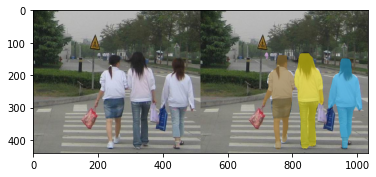

In [ ]:
# 将不同实例的掩膜与原图进行叠加
img_weight=cv2.addWeighted(imgsrc,0.4,all_cls_mask_color,0.6,0)
all_mask=all_cls_mask_index==1
result=np.copy(imgsrc)
result[all_mask]=img_weight[all_mask]
union = np.concatenate((imgsrc,result),axis=1)

# 展示分割结果
plt.imshow(union)
plt.show()

<div id="7"></div>
# 7 YOLACT模型结构

YOLACT是单阶段实例分割算法，将实例分割任务拆分成两个并行的子任务：（1）生成一系列的原型掩模；（2）预测每个实例对应的掩模系数；最后通过线性组合，生成实例Mask。

<div id="7.1"></div>
## 7.1 Backbone

YOLACT使用ResNet101网络作为模型的Backbone，共有5个卷积模块，同时采用了多个尺度的特征图，可以检测到不同尺度的物体。下图为其网络结构：



<div id="7.2"></div>
## 7.2 FPN

因为更深层的特征图能生成稳定性更好的掩膜，而更大的原型掩膜能够使最终生成的掩膜质量更高，且更好地检测到小物体。使用FPN，可以在获得更生成的特征图的同时，保证特征图的大小。


<div id="7.3"></div>
## 7.3 Protonet

受Mask R-CNN结构的启发，YOLACT设计了Protonet结构，输出32个原型掩膜。Protonet由多个$3 \times 3$卷积层、上采样层，和一个$1 \times 1$的卷积层组成。

<div id="7.4"></div>
## 7.4 Prediction Head

Prediction Head部分的输入数据为FPN结构中得到的5个特征图，输出数据为预测得到的掩膜系数。

<div id="8"></div>
# 8 YOLACT分割效果

因为YOLACT模型构建较为复杂，本案例加载已经训练好的模型，代入图像测试其分割效果。

首先配置运行需要的环境，并载入模型。


In [ ]:
!pip install cython
!pip install opencv-python pillow pycocotools matplotlib
!pip install torchvision==0.5.0
!pip install torch==1.4.0
%cd /content
!git clone https://github.com/dbolya/yolact.git
%cd /content/yolact/external/DCNv2
!python setup.py build develop
%cd /content
!git clone https://github.com/adiboy17/download_google_drive.git
!mkdir -p /content/yolact/weights
!python ./download_google_drive/download_gdrive.py 1ZPu1YR2UzGHQD0o1rEqy-j5bmEm3lbyP ./yolact/weights/yolact_plus_resnet50_54_800000.pth

接下来读取数据，为与两阶段实例分割Mask R-CNN算法进行对比，我们选取同一张图像，观察分割结果。

In [ ]:
# 读取数据
!apt install unzip
!unzip test_images.zip

In [ ]:
# 调用函数，对图像进行实例分割
%cd /content
!mkdir -p /content/output_images
!python ./yolact/eval.py --trained_model=./yolact/weights/yolact_plus_resnet50_54_800000.pth --config=yolact_plus_resnet50_config --score_threshold=0.15 --top_k=15 --images=test_images:output_images

下图展示了分割结果，可以看到模型的分割结果较好，头发、手臂等边缘处的分割结果也很准确。且因为YOLACT模型在COCO数据集上进行了预训练，因此能够识别出人、包两种物体，并且展示了标注框内存在该物体的概率。

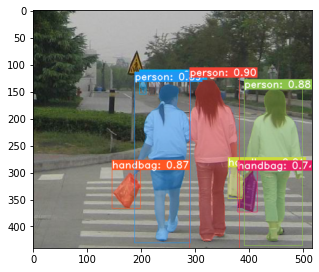

In [ ]:
# 展示分割结果
img = cv2.imread("/content/output_images/FudanPed00060.png")
img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(img_cvt)
plt.show()

<div id="9"></div>
# 9 总结

实例分割在语义分割的基础上，提出了精准识别每个个体的要求。本案例分别展示了两阶段和单阶段实例分割算法。

对于两阶段实例分割，我们采用Mask R-CNN模型。首先调用在COCO数据集上进行预训练的Mask R-CNN模型；再微调模型，即修改模型最后一层，在Penn-Fudan行人检测数据集上进行训练，使模型更适合该数据集。并作图展示实例分割效果，可以证明模型能够精准分割每一个行人个体，展现较好的分割结果。

对于单阶段实例分割，本案例介绍了YOLACT算法，具体介绍了其各个主体部分的作用及结构，并呈现了其准确的实例分割结果。

